In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
nsmc_raw = pd.read_csv('/content/drive/MyDrive/CUAI/nsmc_data.txt', sep='\t').dropna(axis=0)
nsmc_raw.drop_duplicates(subset=['document'], inplace=True) #중복값 처리
aihub_raw = pd.read_excel('/content/drive/MyDrive/CUAI/감성대화말뭉치(최종데이터)_Training.xlsx', engine = "openpyxl")
aihub_raw.head(5)

# aihub데이터 처리

In [3]:
#사용할 데이터만 전처리
aihub_train = aihub_raw.loc[:, ['사람문장1', '사람문장2', '감정_대분류']]
aihub_train['label'] = 0 #전부 label을 0으로 초기화

In [4]:
filt = aihub_train['감정_대분류'] == '기쁨'
aihub_train.loc[filt,'label'] = 1

In [5]:
data1 = aihub_train[['사람문장1', 'label']]
data2 = aihub_train[['사람문장2', 'label']] 
data1.columns = ['document', 'label'] #열 이름 변경
data2.columns = ['document', 'label'] #열 이름 변경

In [6]:
concat_train_data = pd.concat([data1, data2])
concat_train_data.reset_index(inplace = True)
concat_train_data.drop(['index'], axis = 1)

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,1
...,...,...
81753,나한테 아예 떠넘길 거 같은데 친구한테 얘기해볼까 고민 중이야.,0
81754,결과가 좋게 나와서 다행이야,1
81755,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
81756,덕분에 건강도 챙길 수 있고 너무 좋아. 안마기도 있던데 내일은 운동하고 안마기도 ...,1


In [7]:
concat_train_data['document']

0                                아내가 드디어 출산하게 되어서 정말 신이 나.
1                  당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2                  고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3            재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4                             빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
                               ...                        
81753                  나한테 아예 떠넘길 거 같은데 친구한테 얘기해볼까 고민 중이야.
81754                                      결과가 좋게 나와서 다행이야
81755     내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.
81756    덕분에 건강도 챙길 수 있고 너무 좋아. 안마기도 있던데 내일은 운동하고 안마기도 ...
81757                   카페에 가서 대화하거나 같이 술 마시면서 이야기했던 것 같아.
Name: document, Length: 81758, dtype: object

### 문장 분리하기


### 토큰화 & 불용어 처리

In [8]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 66.4 MB/s 


In [9]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from konlpy.tag import *
from tqdm import tqdm
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 특수문자 제거


In [11]:
concat_train_data['document'] = concat_train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [12]:
concat_train_data['document'][1]

'당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야 '

In [13]:
#불용어 정의
stopwords = ['어', '나', '저희', '을', '를', '에', '의', '가', '으로', '로', '에게', '다', '이', '로써', '등', '등등', '여', '조금', '좀','몇',
             '하다', '들', '은', '이야', '게', '도', '것', '이야', '는', '내', '에서', '하고', '고', '요즘', '랑']

#okt 형태소 분석
def okt_tokens(text):
  okt = Okt()
  aihub_train_x = []
  for i in range(0, len(text)):
    tokenized_sent = okt.morphs(text[i], stem=True)
    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
    aihub_train_x.append(stopwords_removed_sent)
    
  return aihub_train_x

#꼬꼬마 형태소 분석
def kkm_tokens(text):
  kkma = Kkma()
  aihub_train_x = []
  for i in range(0, len(text)):
    tokenized_sent =kkma.morphs(text[i])
    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
    aihub_train_x.append(stopwords_removed_sent)

  return aihub_train_x

#코모란 형태소 분석
def komoran_tokens():
  komoran = Komoran()
  aihub_train_x = []
  for i in range(0, len(text)):
    tokenized_sent = komoran.morphs(text[i])
    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
    aihub_train_x.append(stopwords_removed_sent)

aihub_train_data = okt_tokens(concat_train_data['document']) #일단 okt만 사용 (시간이 젤 빠름)

In [19]:
#keras의 토크나이저로 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(aihub_train_data)

In [20]:
#단어 집합 크기 확인
len(tokenizer.word_index) #12409개의 단어

12409

In [16]:
tokenizer.word_index

{'너무': 1,
 '있다': 2,
 '친구': 3,
 '같다': 4,
 '없다': 5,
 '보다': 6,
 '않다': 7,
 '안': 8,
 '되다': 9,
 '좋다': 10,
 '못': 11,
 '말': 12,
 '싶다': 13,
 '만': 14,
 '사람': 15,
 '들다': 16,
 '받다': 17,
 '생각': 18,
 '모르다': 19,
 '돼다': 20,
 '더': 21,
 '돈': 22,
 '정말': 23,
 '자다': 24,
 '수': 25,
 '일': 26,
 '나다': 27,
 '걱정': 28,
 '그렇다': 29,
 '회사': 30,
 '많이': 31,
 '힘들다': 32,
 '한': 33,
 '한테': 34,
 '어떻다': 35,
 '때': 36,
 '가다': 37,
 '거': 38,
 '나르다': 39,
 '아니다': 40,
 '마음': 41,
 '때문': 42,
 '아내': 43,
 '오늘': 44,
 '그': 45,
 '해': 46,
 '스럽다': 47,
 '남편': 48,
 '응': 49,
 '우리': 50,
 '과': 51,
 '기분': 52,
 '야': 53,
 '많다': 54,
 '결혼': 55,
 '화가': 56,
 '슬프다': 57,
 '아프다': 58,
 '이번': 59,
 '먹다': 60,
 '적': 61,
 '오다': 62,
 '집': 63,
 '이제': 64,
 '준비': 65,
 '나오다': 66,
 '인데': 67,
 '나이': 68,
 '왜': 69,
 '주다': 70,
 '라고': 71,
 '직장': 72,
 '아들': 73,
 '다른': 74,
 '지금': 75,
 '일이': 76,
 '엄마': 77,
 '맞다': 78,
 '가족': 79,
 '불안하다': 80,
 '건강': 81,
 '난': 82,
 '되어다': 83,
 '자식': 84,
 '걸': 85,
 '부모님': 86,
 '날': 87,
 '까지': 88,
 '병원': 89,
 '고민': 90,
 '자꾸': 91,
 '해주다': 92,
 '혼자

In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12409
등장 빈도가 2번 이하인 희귀 단어의 수: 4987
단어 집합에서 희귀 단어의 비율: 40.18857281005722
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8546127439357546


In [18]:
vocab_size = total_cnt - rare_cnt + 1 
print(vocab_size)

7423


In [21]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(aihub_train_data)
X_train = tokenizer.texts_to_sequences(aihub_train_data)
X_train[:3]

[[43, 376, 445, 83, 23, 828],
 [507, 1500, 42, 60, 320, 692, 290, 1112, 129, 53],
 [737, 1972, 1790, 36, 6, 688, 132, 1219, 94, 47]]

In [22]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] #결측치 확인
#확인 되는게 없음 => 결측치는 없다

최대 길이 : 43
평균 길이 : 9.410602020597373


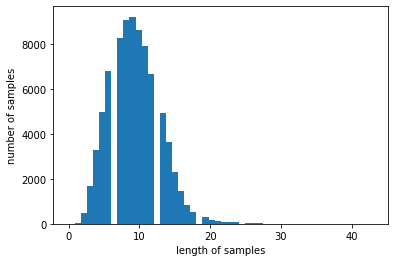

In [ ]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 99.89970400450109


In [ ]:
#패딩 => 길이는 25
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
print(X_train)

[[  43  376  445 ...    0    0    0]
 [ 507 1500   42 ...    0    0    0]
 [ 737 1972 1790 ...    0    0    0]
 ...
 [2142  264    6 ...    0    0    0]
 [ 610   81  217 ...    0    0    0]
 [1821   37  200 ...    0    0    0]]


# NSMC 데이터

In [ ]:
nsmc_raw

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [ ]:
nsmc_raw.drop_duplicates(subset=['document'], inplace=True) #중복값 제거

In [ ]:
nsmc = nsmc_raw[['document', 'label']]
nsmc

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199995,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,쓰.레.기,0
199997,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


### 글자가 아닌 것 제거

In [ ]:
#글자가 아닌 것 제거
nsmc['document'] = nsmc['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
nsmc.drop_duplicates(subset=['document'], inplace=True) #중복값 제거
nsmc = nsmc.dropna(how = 'any') #null값 제거
nsmc

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
199994,개연성이 없어요 별루다,0
199995,포켓 몬스터 짜가 ㅡㅡ,0
199997,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0
199998,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


### 맞춤법 검사하기

In [ ]:
#맞춤법 검사기 다운로드
!pip install git+https://github.com/ssut/py-hanspell.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-4i4_5wyi
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-4i4_5wyi
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=659560cd53196caf3c78d868702aaeb2a6ad7e348c0c8a43a22f4bf8d9538cbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnagog0v/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
#맞춤법 검사
from hanspell import spell_checker

nsmc_train_x = []
for sent in tqdm(nsmc['document']):
    nsmc_train_x.append(spell_checker.check(sent))

### 띄어쓰기 검사하기

In [ ]:
#PyKoSpacing 다운로드
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-qohtt_yj
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-qohtt_yj
     |████████████████████████████████| 671.4 MB 1.8 kB/s 
     |████████████████████████████████| 463 kB 6.9 MB/s 
     |████████████████████████████████| 1.3 MB 54.2 MB/s 
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2268577 sha256=07f5917a374adcebbc09c0b274eddbf6b4fbcc234f6f37f6162999767633da96
  Stored in directory: /tmp/pip-ephem-wheel-cache-88ndhthi/wheels/9b/93/81/a2a7dc8c66ede5bf30634d20635f32b95eac7ca2ea8844058b
Successfully built pykospacing
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempti

In [ ]:
#띄어쓰기 체크
from pykospacing import Spacing

spacing = Spacing()

nsmc_spacing_sent = []

for sent in tqdm(nsmc_train_x['document']):
  spacing_sent.append(spacing(sent))

### 형태소 분석


In [ ]:


#okt를 사용하여 형태소 분석
nsmc_train_data = okt_tokens(nsmc_spacing_sent['document'])